### CAPM Beta and Volatility Estimation 
Author : Osho Sharma 


This file includes code to find yearly CAPM beta, along with systematic and idiosyncratic risk using monthly stock return data from CRSP (1996-2023)

In [1]:
#import libraries 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns

In [2]:
# import data 
data = pd.read_csv('./MSF_1996_2023.csv')

/var/folders/qq/4_7zbq5x7dx8hhvz65nzsm740000gn/T/ipykernel_10975/3716030037.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('./MSF_1996_2023.csv')


#### Data Cleaning and Wrangling

In [3]:
data_filtered = data.filter(items=['date', 'PERMCO', 'vwretd', 'RET', 'SICCD',])
data_filtered.rename(columns = {'vwretd': 'market_return','RET': 'firm_return', 'TICKER' : 'ticker', 'SICCD' : 'industry_code', 'PERMCO': 'company_id'}, inplace = True)


# convert all industry code to numeric and handle errors.
data_filtered['industr_code_numeric'] = pd.to_numeric(data_filtered['industry_code'], errors='coerce')  
data_filtered = data_filtered.dropna(subset=['industr_code_numeric'])
data_filtered['industry_code'] = data_filtered['industry_code'].astype(int)
data_filtered.drop(columns=['industr_code_numeric'], inplace=True)

# Industry ranges SIC code 
industry_ranges = { 
    'Agriculture': (1,999), 
    'Mining': (1000,1499),
    'Construction': (1500,1799),
    'Manufacturing': (2000,3999),
    'Transportation': (4000,4999),
    'Wholesale Trade': (5000,5199),
    'Retail Trade': (5200,5999),
    'Finance': (6000,6799),
    'Services': (7000,8999),
    'Public Administration': (9000,9999)
}

# add new column for industry_name using industry_ranges
data_filtered['industry_name'] = data_filtered['industry_code'].apply(lambda x: next((k for k, v in industry_ranges.items() if v[0] <= x <= v[1]), None))
data_filtered['year'] = data_filtered['date'].str[:4]



# Filter ind_data to include monthly rows for 10 unique companies per industry_name for each year
sampled_data = data_filtered.groupby(['industry_name', 'year']).apply(
    lambda group: group[group['company_id'].isin(group.drop_duplicates('company_id').head(10)['company_id'])]
).reset_index(drop=True)

# convert all firm return & market return to float and handle errors.
sampled_data['firm_return_float'] = pd.to_numeric(sampled_data['firm_return'], errors='coerce')  
sampled_data = sampled_data.dropna(subset=['firm_return_float'])
sampled_data['firm_return'] = sampled_data['firm_return'].astype(float)
sampled_data.drop(columns=['firm_return_float'], inplace=True)
sampled_data['market_return'] = sampled_data['market_return'].astype(float)


/var/folders/qq/4_7zbq5x7dx8hhvz65nzsm740000gn/T/ipykernel_10975/3937067863.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_data = data_filtered.groupby(['industry_name', 'year']).apply(


In [4]:
sampled_data.head(24)

,date,company_id,market_return,firm_return,industry_code,industry_name,year
0,1996-01-31,9437,0.028121,0.109577,170,Agriculture,1996
1,1996-02-29,9437,0.016353,0.044586,170,Agriculture,1996
2,1996-03-29,9437,0.010914,0.067073,170,Agriculture,1996
3,1996-04-30,9437,0.025560,0.214629,170,Agriculture,1996
4,1996-05-31,9437,0.026810,0.056604,170,Agriculture,1996
5,1996-06-28,9437,-0.008289,0.071429,170,Agriculture,1996
6,1996-07-31,9437,-0.053851,-0.064000,170,Agriculture,1996
7,1996-08-30,9437,0.032451,0.285714,170,Agriculture,1996
8,1996-09-30,9437,0.052985,-0.055556,170,Agriculture,1996
9,1996-10-31,9437,0.013673,0.132353,170,Agriculture,1996


#### Linear Regression for Beta Estimation

In [5]:
def calculate_beta_for_window(sub_df, window, results):
    for year in sub_df['year'].unique():
        # Filter the data for the current year
        df_year = sub_df[sub_df['year'] == year]

        # For each row in the current year, get the last 'window' months of data
        for index, row in df_year.iterrows():
            df_last_n_months = sub_df[(sub_df['date'] <= row['date'])].tail(window)

            if len(df_last_n_months) == window:  # Ensure we have the required window of data
                # Market returns (X) and stock returns (Y)
                X = df_last_n_months[['excess_market_return']]
                y = df_last_n_months['excess_firm_return']

                # Fit linear regression
                model = LinearRegression()
                model.fit(X, y)
                y_actual = row['excess_firm_return']
                y_pred = model.predict([[row['excess_market_return']]])[0]
                residual = y_actual - y_pred    

                # Get beta (the coefficient of market returns)
                beta = model.coef_[0]
                
                # Append the result for this company, year, and window
                results.append({
                    'company_id': row['company_id'],
                    'year': row['year'],
                    'date': row['date'],
                    'window': window,  # Store the window size (12, 24, or 36)
                    'beta': beta,
                    'residual': residual, 
                    'industry': row['industry_name']
                })

In [6]:
# suppress unnecessary warnings
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

# calculate excess returns.
rf_rate_monthly = 0.0425/12
sampled_data['excess_firm_return'] = sampled_data['firm_return'] - rf_rate_monthly
sampled_data['excess_market_return'] = sampled_data['market_return'] - rf_rate_monthly

results = []

# Calculate beta for 12, 24, and 36 month windows for each security - using linear regression.
windows = [12, 24, 36]
for window in windows:
    sampled_data.groupby('company_id').apply(lambda group: calculate_beta_for_window(group, window, results))


beta_data = pd.DataFrame(results)



/var/folders/qq/4_7zbq5x7dx8hhvz65nzsm740000gn/T/ipykernel_10975/703111629.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_data.groupby('company_id').apply(lambda group: calculate_beta_for_window(group, window, results))
/var/folders/qq/4_7zbq5x7dx8hhvz65nzsm740000gn/T/ipykernel_10975/703111629.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_data.groupby('company_id').apply(lambda 

In [7]:
beta_data.head(24)

,company_id,year,date,window,beta,residual,industry
0,37,1996,1996-12-31,12,0.298438,0.061831,Wholesale Trade
1,37,1997,1997-01-31,12,0.102284,-0.047948,Wholesale Trade
2,37,1997,1997-02-28,12,0.053202,0.034905,Wholesale Trade
3,37,1997,1997-03-31,12,-0.017706,0.008890,Wholesale Trade
4,37,1997,1997-04-30,12,-0.027904,-0.007757,Wholesale Trade
5,37,1997,1997-05-30,12,0.093821,0.028586,Wholesale Trade
6,37,1997,1997-06-30,12,0.316679,0.091888,Wholesale Trade
7,37,1997,1997-07-31,12,0.114469,0.023564,Wholesale Trade
8,37,1997,1997-08-29,12,-0.440934,0.119427,Wholesale Trade
9,37,1997,1997-09-30,12,-0.443052,0.030304,Wholesale Trade


#### Descriptive Statistics by Industry

In [8]:
def custom_describe(group):
    return group.agg({
        'mean': 'mean',
        'std': 'std',
        'min': 'min',
        '1%': lambda x: x.quantile(0.01),  # 1st percentile
        '5%': lambda x: x.quantile(0.05),  # 5th percentile
        '25%': lambda x: x.quantile(0.25), # 25th percentile (first quartile)
        '50%': lambda x: x.quantile(0.50), # 50th percentile (median)
        '75%': lambda x: x.quantile(0.75), # 75th percentile (third quartile)
        '95%': lambda x: x.quantile(0.95), # 95th percentile
        '99%': lambda x: x.quantile(0.99), # 99th percentile
        'max': 'max'
    })

# Group by 'industry', 'window', and 'year' and apply the custom aggregation
beta_stats = beta_data.groupby(['industry', 'window', 'year'])['beta'].apply(custom_describe)
beta_stats = beta_stats.unstack().reset_index()

#### Plotting CAPM Beta's Mean and Standard Deviation Per Industry

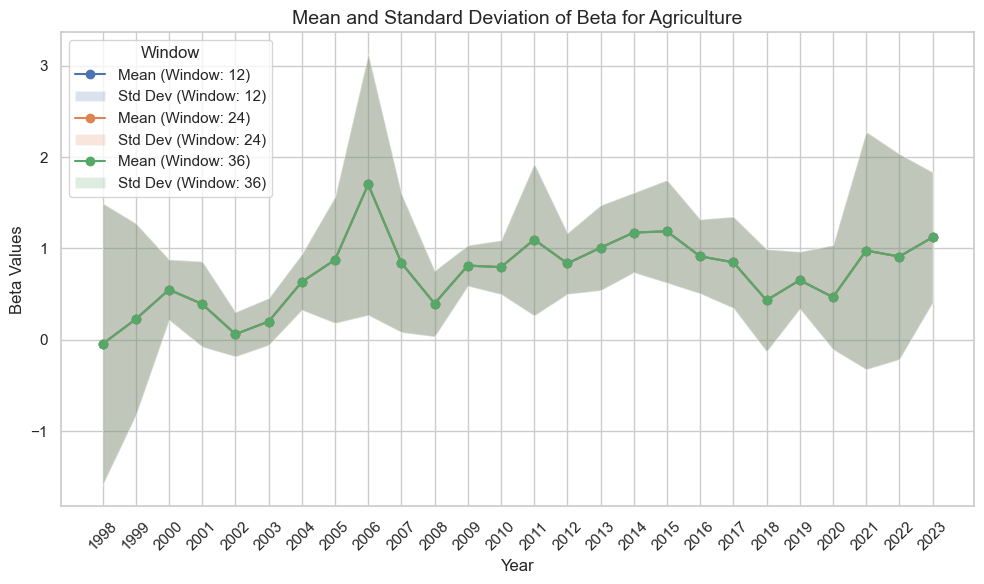

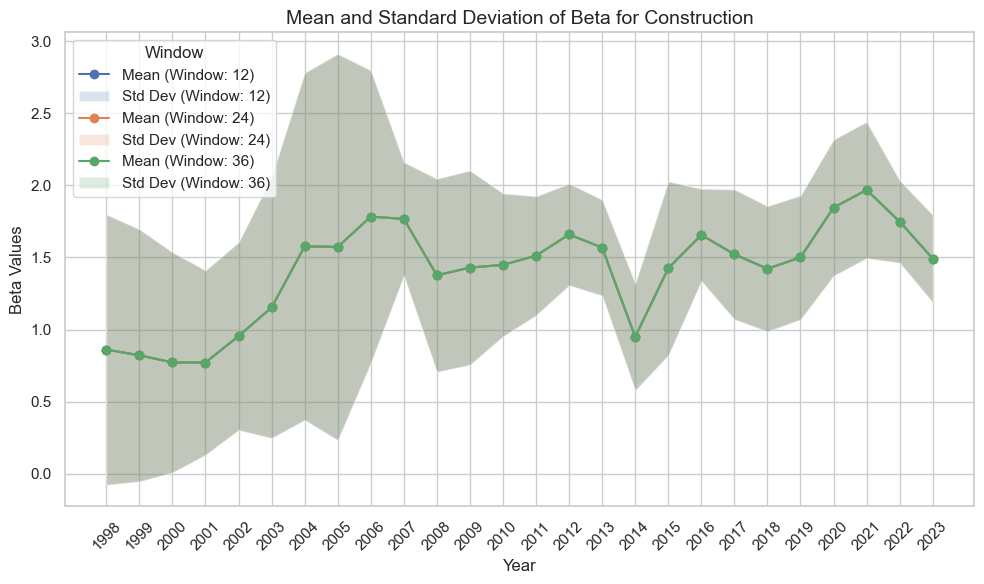

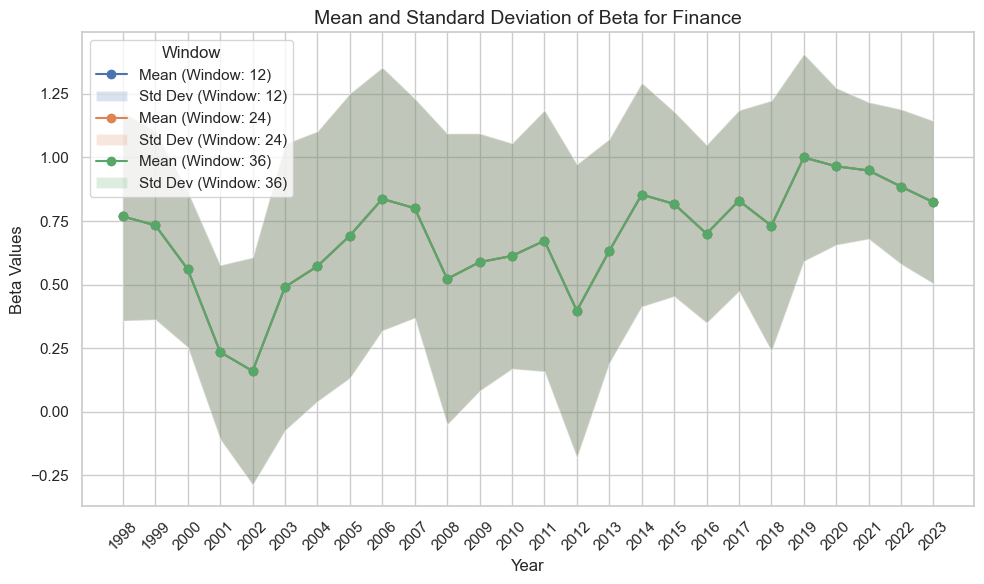

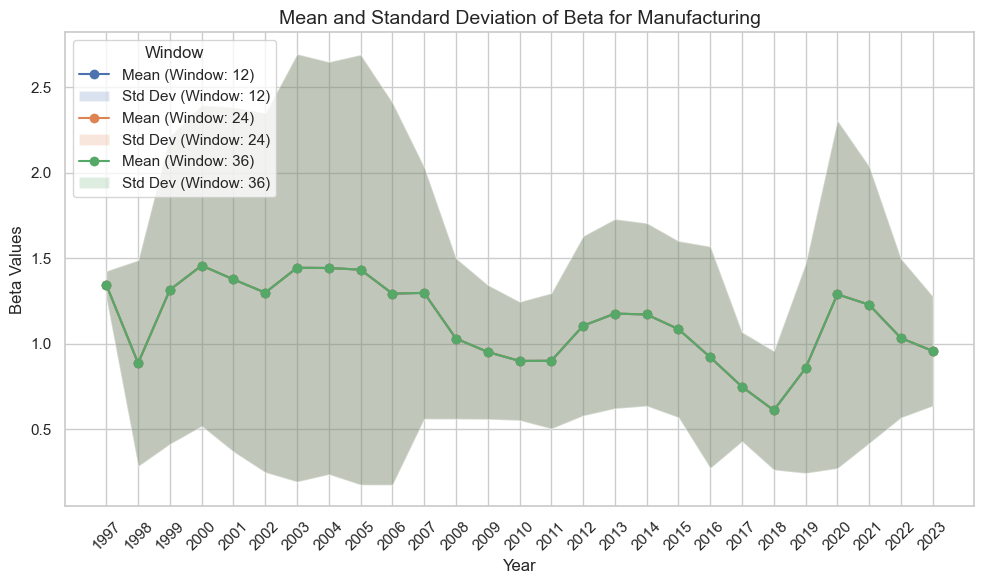

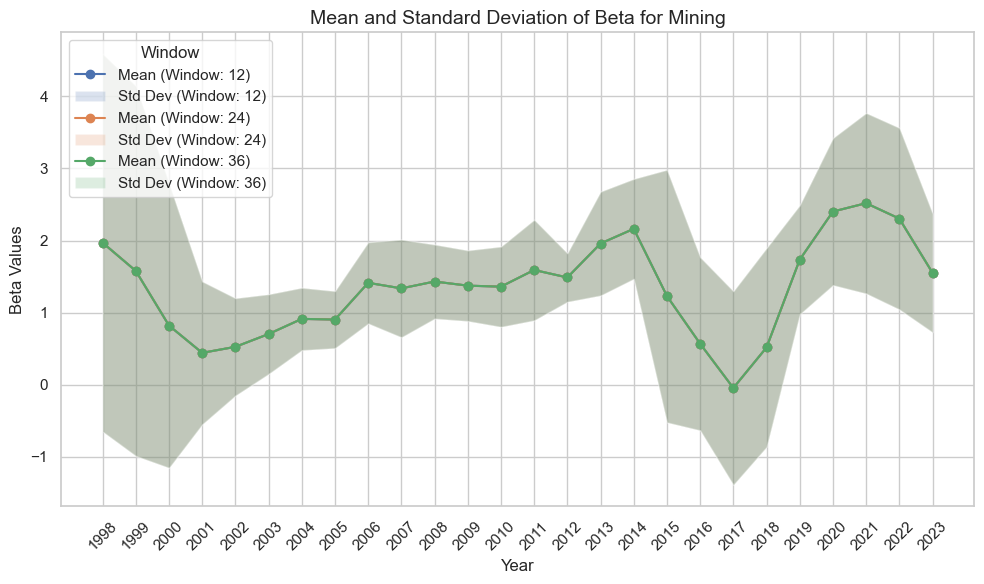

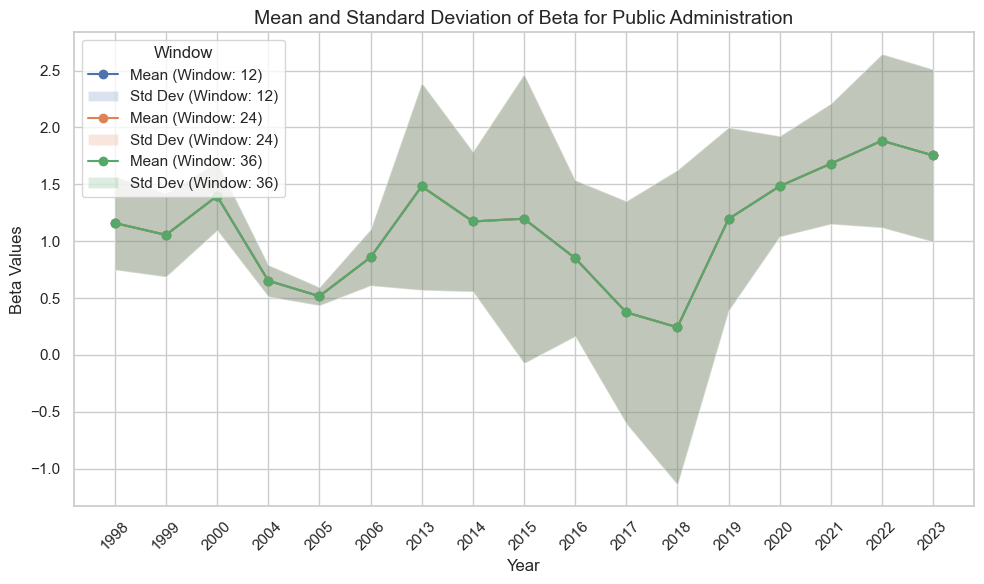

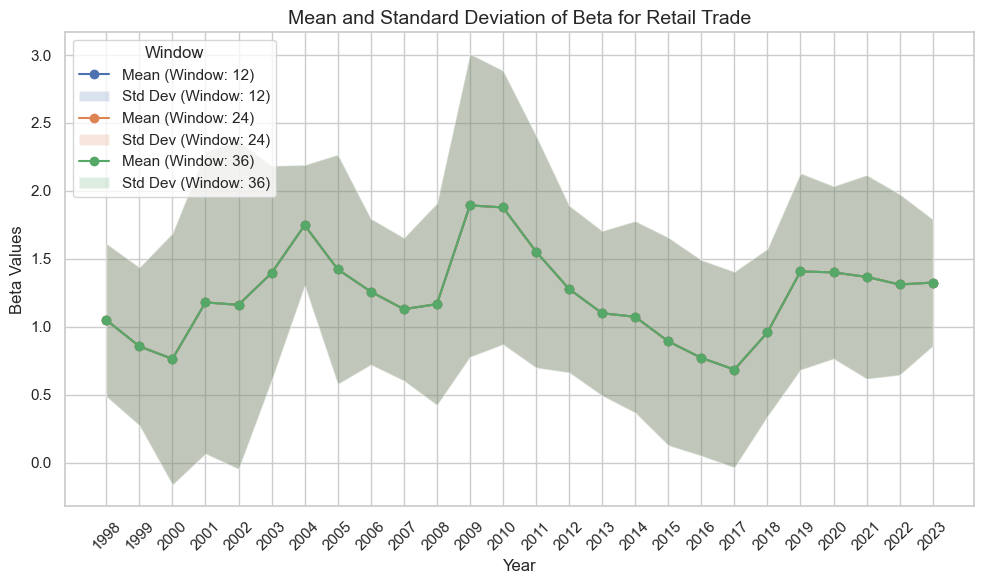

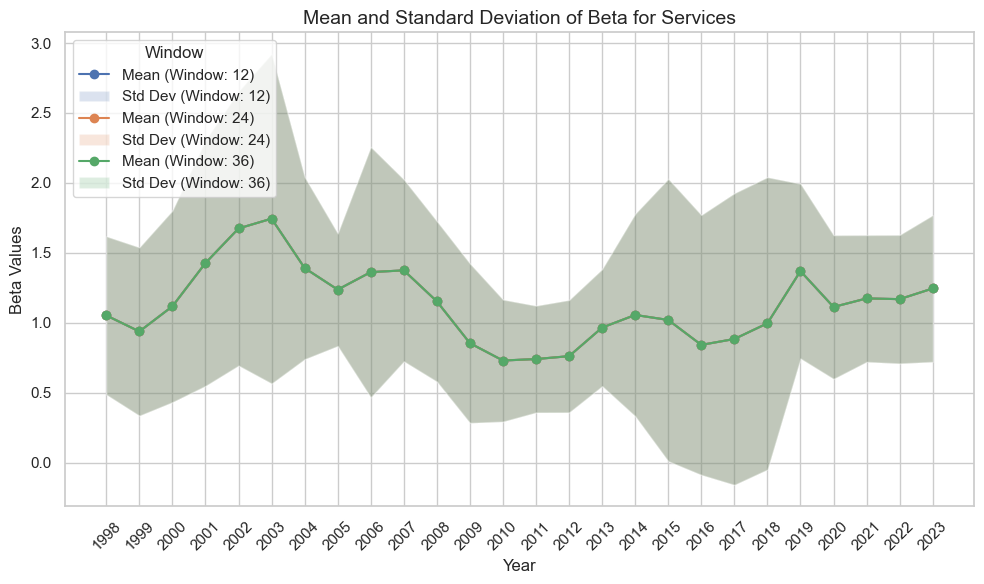

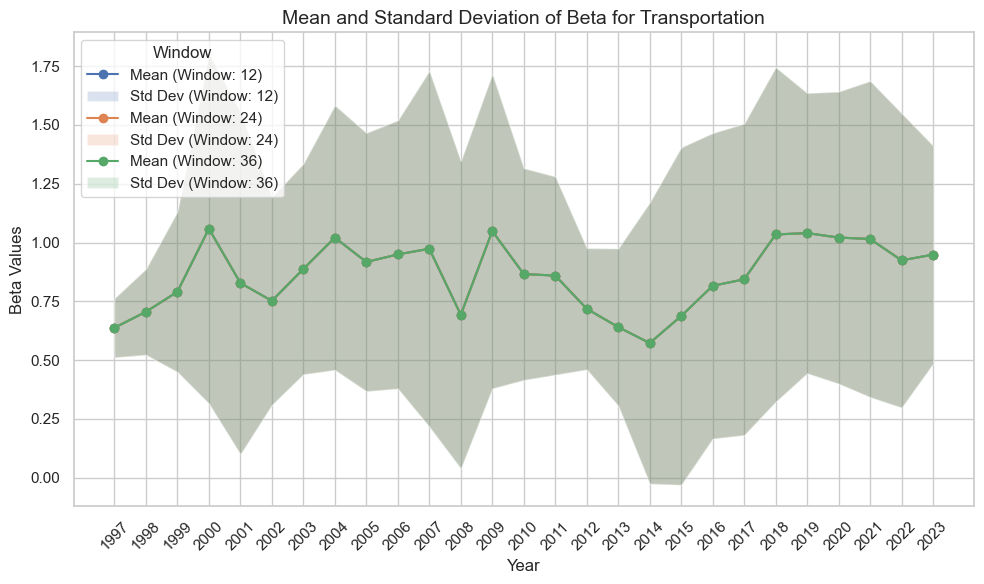

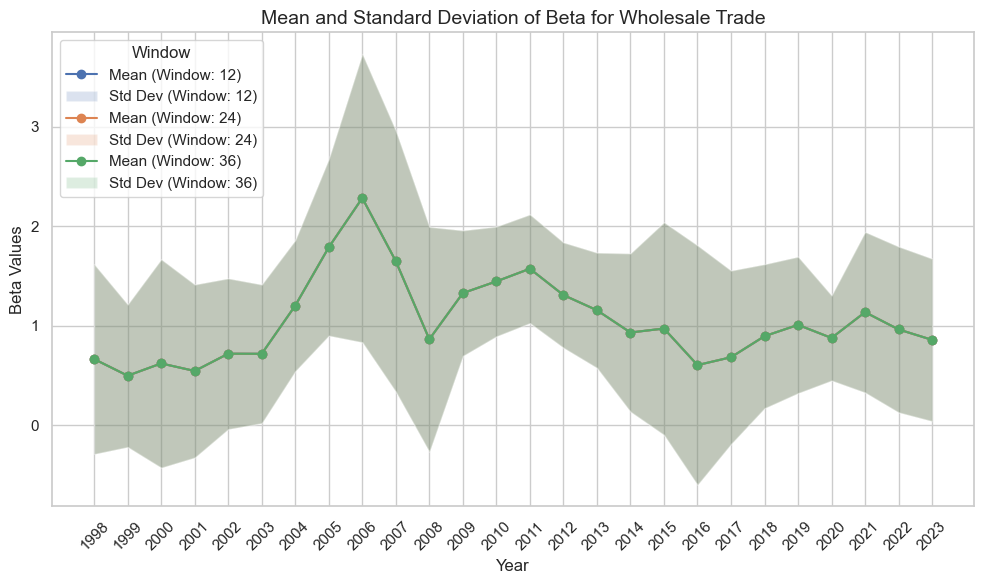

In [9]:
# Get the list of unique industries
industries = beta_stats['industry'].unique()

# Set seaborn plot style
sns.set(style="whitegrid")

# Loop through each industry and create a plot for it
for industry in industries:
    # Filter the DataFrame for the current industry
    industry_data = beta_stats[beta_stats['industry'] == industry]
    
    # Create a new plot
    plt.figure(figsize=(10, 6))
    
    # Plot the mean of beta over the years
    for window in industry_data['window'].unique():
        # Filter for each window
        window_data = industry_data[industry_data['window'] == 36]
        
        # Plot the mean line
        plt.plot(window_data['year'], window_data['mean'], label=f'Mean (Window: {window})', marker='o')
        
        # Plot the shaded area representing the std
        plt.fill_between(window_data['year'], 
                         window_data['mean'] - window_data['std'], 
                         window_data['mean'] + window_data['std'], 
                         alpha=0.2, label=f'Std Dev (Window: {window})')
    
    # Add titles and labels
    plt.title(f'Mean and Standard Deviation of Beta for {industry}', fontsize=14)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Beta Values', fontsize=12)
    
    # Add legend
    plt.legend(title='Window', loc='upper left')
    
    # Display the plot
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()